In [1]:
"""
Pairwise registration evaluation with meanshift filter denoising for both affine and deformable registration.
"""
import sys
sys.path.append('..')
sys.path.append('../../spami/')
import time
import shutil

import json
import os
from os.path import join, exists

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SimpleITK as sitk

from GreedyFHist.registration import GreedyFHist, get_default_args


from miit.reg_graph import RegGraph
from miit.utils.utils import create_if_not_exists, clean_configs
from miit.utils.metrics import compute_tre, compute_tre_sections_

        

def get_core_names():
    return [x.split('.')[0] for x in os.listdir('../../spami/configs/cores_hr/')]


# def get_default_args():
#     return {
#         'resolution': 1024,
#         'use_segmentation_masks': True,    
#         'output_dir': '../save_directories/temp_pairwise/',
#         'tmp_dir': '../save_directories/temp_pairwise/tmp',
#         'cleanup_temporary_directories': False,
#         'remove_temp_directory': False,
#         'cost_fun': 'WNCC',
#         'ia': 'ia-com-init',
#         'affine_use_denoising': True,
#         'deformable_use_denoising': True
# }


def main():
    skip_processed_cores = True
    root_dir = '../save_directories/pairwise_analysis/greedy_f_hist_params'
    if not os.path.exists(root_dir):
        os.mkdir(root_dir)
    core_names = get_core_names()
    df_all = pd.DataFrame()
    resolutions = [128, 256, 512, 1024, 2048]
    for resolution in resolutions:
        res_target_dir = f'{root_dir}/{resolution}'
        create_if_not_exists(res_target_dir)
        for core_name in core_names:
            print(f'Working resolution: {resolution} and core: {core_name}')       
            target_dir = join(res_target_dir, core_name)
            # if os.path.exists(target_dir) and skip_processed_cores:
            #     print('Already processed!')
            #     continue
            create_if_not_exists(target_dir)
            config_path = os.path.join('../../spami/configs/cores_hr/', core_name + '.json')

            with open(config_path, 'r') as f:
                config = json.load(f)
                config = clean_configs(config)
                # config = filter_node_ids(config, section_ids)
            graph = RegGraph.from_config(config)        
            df_core = pd.DataFrame()
            section_ids = list(graph.sections)
            # paddings = get_symmetric_padding_for_sections([graph.sections[x] for x in section_ids])

            for i in range(len(section_ids)-1):
                source_idx = section_ids[i]
                target_idx = section_ids[i+1]
                source_section = graph.sections[source_idx].copy()
                target_section = graph.sections[target_idx].copy()
                if source_section.landmarks is None or target_section.landmarks is None:
                    continue
                print(f'Now processing: {source_idx} and {target_idx}')
                sub_dir = join(target_dir, f'{source_idx}_{target_idx}')
                create_if_not_exists(sub_dir)
                warp_dir = join(sub_dir, 'warped_section')
                create_if_not_exists(warp_dir)
                args = get_default_args()
                args['resolution'] = resolution
                create_if_not_exists(args['output_dir'])
                start = time.time()
                registration_result = graph.default_registerer.coregister_images(moving_img=source_section.image.data,
                                                                                 fixed_img=target_section.image.data,
                                                                                 moving_img_mask=source_section.segmentation_mask.data,
                                                                                 fixed_img_mask=target_section.segmentation_mask.data,
                                                                                 args=args)  
                warped_section = source_section.warp(graph.default_registerer, registration_result, args) # Warp section here
                if exists(args['output_dir']):
                    shutil.rmtree(args['output_dir'])
                end = time.time()
                duration = end - start
                mean_rtre, median_rtre, mean_tre, median_tre = compute_tre(target_section, warped_section)
                row = {
                    'core_name': core_name,
                    'fixed_section_id': target_idx,
                    'moving_section_id': source_idx,
                    'mean_rtre': mean_rtre,
                    'median_rtre': median_rtre,
                    'mean_tre': mean_tre,
                    'median_tre': median_tre,
                    'duration': duration,
                    'resolution': resolution
                }
                print(row)
                row = pd.DataFrame(row, index=[0])
                df_core = pd.concat([df_core, row]).reset_index(drop=True)

            df_core.to_csv(join(target_dir, 'stats.csv'))
            df_all = pd.concat([df_all, df_core]).reset_index(drop=True)
        df_all.to_csv(join(root_dir, 'stats.csv'))
                    

# if __name__ == '__main__':
#     main()


WARNING ⚠️ user config directory '/mnt/work/workbench/maximilw/.config/Ultralytics' is not writeable, defaulting to '/tmp' or CWD.Alternatively you can define a YOLO_CONFIG_DIR environment variable for this path.


In [2]:
skip_processed_cores = True
root_dir = '../save_directories/pairwise_analysis/greedy_f_hist_params'
if not os.path.exists(root_dir):
    os.mkdir(root_dir)
core_names = get_core_names()
df_all = pd.DataFrame()
resolutions = [128, 256, 512, 1024, 2048]
resolutions = [1024]
registerer = GreedyFHist(path_to_greedy='/mnt/work/workbench/maximilw/applications/test/greedy/build2/greedy')

for resolution in resolutions:
    res_target_dir = f'{root_dir}/{resolution}'
    create_if_not_exists(res_target_dir)
    for core_name in core_names:
        if core_name != '045_02':
            continue
        print(f'Working resolution: {resolution} and core: {core_name}')       
        target_dir = join(res_target_dir, core_name)
        # if os.path.exists(target_dir) and skip_processed_cores:
        #     print('Already processed!')
        #     continue
        create_if_not_exists(target_dir)
        config_path = os.path.join('../../spami/configs/cores_hr/', core_name + '.json')

        with open(config_path, 'r') as f:
            config = json.load(f)
            config = clean_configs(config)
            # config = filter_node_ids(config, section_ids)
        graph = RegGraph.from_config(config)        
        df_core = pd.DataFrame()
        section_ids = list(graph.sections)
        # paddings = get_symmetric_padding_for_sections([graph.sections[x] for x in section_ids])

        for i in range(len(section_ids)-1):
            source_idx = section_ids[i]
            target_idx = section_ids[i+1]
            if source_idx != 8 and target_idx != 9:
                continue
            source_section = graph.sections[source_idx].copy()
            target_section = graph.sections[target_idx].copy()
            if source_section.landmarks is None or target_section.landmarks is None:
                continue
            print(f'Now processing: {source_idx} and {target_idx}')
            sub_dir = join(target_dir, f'{source_idx}_{target_idx}')
            create_if_not_exists(sub_dir)
            # args = get_default_args()
            args = get_default_args()
            args['resolution'] = (resolution, resolution)
            start = time.time()
            if exists(args['output_dir']):
                shutil.rmtree(args['output_dir'])
            create_if_not_exists(args['output_dir'])
            registration_result = registerer.register(moving_img=source_section.image.data,
                                                                             fixed_img=target_section.image.data,
                                                                             moving_img_mask=source_section.segmentation_mask.data,
                                                                             fixed_img_mask=target_section.segmentation_mask.data,
                                                                             args=args)  
            warped_section = source_section.warp(registerer, registration_result, args) # Warp section here
            break
        break
    break
#             end = time.time()
#             duration = end - start
#             mean_rtre, median_rtre, mean_tre, median_tre = compute_tre(target_section, warped_section)
#             row = {
#                 'core_name': core_name,
#                 'fixed_section_id': target_idx,
#                 'moving_section_id': source_idx,
#                 'mean_rtre': mean_rtre,
#                 'median_rtre': median_rtre,
#                 'mean_tre': mean_tre,
#                 'median_tre': median_tre,
#                 'duration': duration,
#                 'resolution': resolution
#             }
#             print(row)
#             row = pd.DataFrame(row, index=[0])
#             df_core = pd.concat([df_core, row]).reset_index(drop=True)

#         df_core.to_csv(join(target_dir, 'stats.csv'))
#         df_all = pd.concat([df_all, df_core]).reset_index(drop=True)
#     df_all.to_csv(join(root_dir, 'stats.csv'))

Working resolution: 1024 and core: 045_02
Now processing: 8 and 9


In [3]:
compute_tre_sections_(target_section, warped_section)

(0.012532249945747484,
 0.004919623732173248,
 50.08699915053578,
 19.662007282094642)

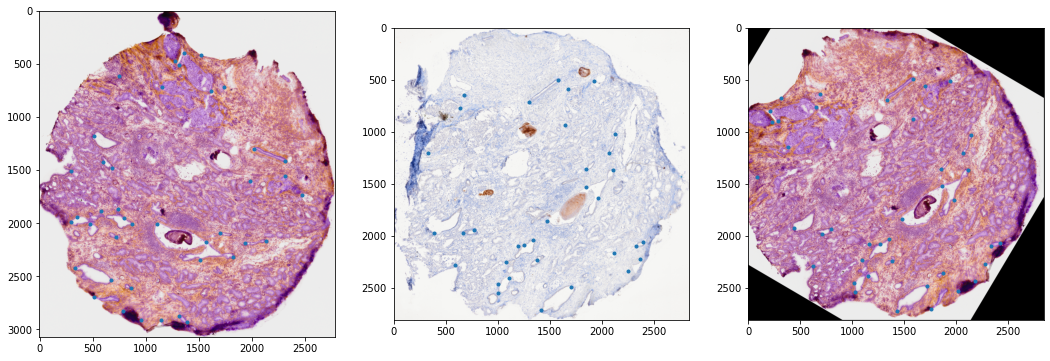

In [4]:
_, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(source_section.image.data)
axs[0].plot(source_section.landmarks.data.x, source_section.landmarks.data.y, '.')
axs[1].imshow(target_section.image.data)
axs[1].plot(target_section.landmarks.data.x, target_section.landmarks.data.y, '.')
axs[2].imshow(warped_section.image.data)
axs[2].plot(warped_section.landmarks.data.x, warped_section.landmarks.data.y, '.')


In [11]:
registration_result.reg_results[0].path_to_big_warp

'save_directories/temp_nb/registrations/0/metrics/full_resolution/big_warp.nii.gz'

In [16]:
target_section.image.data.shape, warped_section.image.data.shape

((2808, 2844, 3), (3072, 2781, 3))

In [17]:
source_section.image.data.shape

(3072, 2781, 3)

In [20]:
a = sitk.GetArrayFromImage(sitk.ReadImage('../save_directories/temp_pairwise/tmp/moving_denoised/new_small_image.nii.gz'))
b = sitk.GetArrayFromImage(sitk.ReadImage('../save_directories/temp_pairwise/tmp/fixed_denoised/new_small_image.nii.gz'))


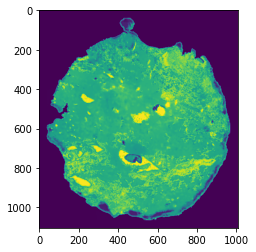

In [21]:
plt.imshow(a)

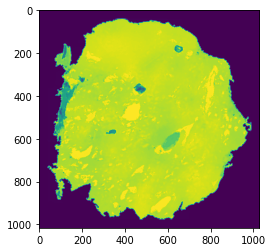

In [22]:
plt.imshow(b)

In [4]:
default_args = get_default_args()

In [5]:
default_args

{'kernel': 10,
 'resolution': (1024, 1024),
 'use_segmentation_masks': True,
 'output_dir': 'save_directories/temp_nb/',
 'tmp_dir': 'save_directories/temp_nb/tmp',
 'cleanup_temporary_directories': False,
 'remove_temp_directory': False,
 'cost_fun': 'WNCC',
 'ia': 'ia-com-init',
 'affine_use_denoising': True,
 'deformable_use_denoising': True,
 'pre_downsampling_factor': 1}

In [13]:
registration_result

MultiRegResult(reg_results=OrderedDict([(0, RegResult(path_to_small_affine='save_directories/temp_nb/registrations/0/metrics/small_resolution/small_affine.mat', path_to_big_affine='save_directories/temp_nb/registrations/0/metrics/full_resolution/Affine.mat', path_to_small_warp='save_directories/temp_nb/registrations/0/metrics/small_resolution/small_warp.nii.gz', path_to_big_warp='save_directories/temp_nb/registrations/0/metrics/full_resolution/big_warp.nii.gz', path_to_small_inv_warp='save_directories/temp_nb/registrations/0/metrics/small_resolution/small_inv_warp.nii.gz', path_to_big_inv_warp='save_directories/temp_nb/registrations/0/metrics/full_resolution/big_warp_inv.nii.gz', width_downscaling_factor=0.33344187561055033, height_downscaling_factor=0.33344187561055033, path_to_small_fixed='save_directories/temp_nb/tmp/0/fixed_denoised/new_small_image.nii.gz', path_to_small_moving='save_directories/temp_nb/tmp/0/moving_denoised/new_small_image.nii.gz', cmdl_log=[CompletedProcess(args=

In [5]:
reg_configs = [
    {'resolution': (128, 128), 'kernel': 2},
    {'resolution': (256, 256), 'kernel': 3},
    {'resolution': (512, 512), 'kernel': 5},
    {'resolution': (1024, 1024), 'kernel': 10},
    {'resolution': (2048, 2038), 'kernel': 20}
]

In [6]:
reg_configs

[{'resolution': (128, 128), 'kernel': 2},
 {'resolution': (256, 256), 'kernel': 3},
 {'resolution': (512, 512), 'kernel': 5},
 {'resolution': (1024, 1024), 'kernel': 10},
 {'resolution': (2048, 2038), 'kernel': 20}]

In [7]:
for reg_config in reg_configs:
    print(reg_config['resolution'][0])

128
256
512
1024
2048
